In [ ]:
# %load stat_metrics_compare_ensemble_and_SILO.py
"""
Created on Tue Apr 23 14:12:09 2019

@author: nav00a
"""

# xarray opens the netcdf file
import xarray as xr
import requests
import io
import pandas as pd
from plotnine import *
import datetime

nc = xr.open_dataset("../data/ensemble_siloaccess_s.nc")
# type nc in the console to see a summary of the object incl. attributes, dimensions and variables

# Interesting behaviour from xarray: if we define a variable with name "days" and units "days since Jan 1st 1970",
# it automatically reads it in as a datetime object!! It won't do it otherwise, but since this is what we want,
# we just go with it.

# Get some properties (attributes) from the netcdf file
# Attributes are values that the creator of the file has provided as a sort of header
start_month = nc.attrs["hindcast_start_month"]
lon = nc.attrs["longitude"]
lat = nc.attrs["latitude"]

# Get time bounds properties of the .nc file, which aren't declared attributes
minyear = int(min(nc.year))
maxyear = int(max(nc.year))

# Now we convert the imported netcdf object to a pandas dataframe
ensemble_df = nc.to_dataframe().reset_index()
# Can't remember why I convert date to a string, but it was needed for grouping I think (won't work well with a datetime object)
# We also create a "date" column, because it makes more sense than a "days" column formatted as a date
# A "date" column also plays along nicely with the SILO dataset
ensemble_df["date"] = ensemble_df["days"].astype(str)
# Delete "days" column
ensemble_df = ensemble_df.drop(columns="days")


# Get SILO data to compare ensemble with it

# Set SILO url download link (specifying csv format)
silourl = "https://dcdp.research.csiro.au/silogrid?lat="+ str(lat)  +"&lon=" + str(lon) +" &format=csv&start=" + str(minyear) +"0101&stop=" + str(maxyear) +"1231"
# Download SILO data
httpreq = requests.get(silourl, verify=False)

# Use the StringIO function to interpret the csv-like object as if it was saved to disk, then read_csv into pandas
silo_df = pd.read_csv(io.StringIO(httpreq.content.decode('utf-8')))
# This is to remove the header row
silo_df = silo_df.iloc[1:]
# Set columns to correct format
silo_df["date"] = silo_df["date"].astype(str)
silo_df["rad"] = silo_df["rad"].astype(float)
silo_df["tmax"] = silo_df["tmax"].astype(float)
silo_df["tmin"] = silo_df["tmin"].astype(float)
silo_df["rain"] = silo_df["rain"].astype(float)
silo_df["vp"] = silo_df["vp"].astype(float)
silo_df["evap"] = silo_df["evap"].astype(float)


# Compare ensemble and SILO

# We calculate the mean of the ensemble as this is what we want to evaluate
ensemble_df_mean = ensemble_df.groupby(["date"]).mean().reset_index()

# ANALYSIS 

# Plot using ggplot2 for python (plotnine). Currently not too pretty, need to find how to mend the looks
(ggplot(ensemble_df_mean.where(ensemble_df_mean["rain"]>0.1))+
  geom_density(mapping= aes(x = "rain"), color="red", size=1) +
  geom_density(data=silo_df.where(silo_df["rain"]>0.1), mapping= aes(x = "rain"), color="white", size=1, linetype='dotted') +
  theme_minimal()+
  coord_cartesian(xlim =(0, 20))
  )

# Calculate ensemble performance metrics (based on http://www.cawcr.gov.au/projects/verification/)
# We won't use correlation as we're not interested in predicting daily weather but the actual pattern of climate
fcast_vs_obs = ensemble_df_mean.merge(silo_df, on= 'date')

fcast_vs_obs.rename(columns = {"date":"date", "ens":"ens", "rad_x":"rad.fcast","tmax_x":"tmax.fcast","rain_x":"rain.fcast","tmin_x":"tmin.fcast","rad_y":"rad.obs","tmax_y":"tmax.obs","tmin_y":"tmin.obs","rain_y":"rain.obs","vp":"vp.obs","evap":"evap.obs"}, inplace=True)

# Mean error - Answers the question: What is the average forecast error?
# We don't really want this for AgScore but it's informative
fcast_vs_obs["error"] = fcast_vs_obs["rain.fcast"] - fcast_vs_obs["rain.obs"]
mean_error = fcast_vs_obs["error"].mean()
print (mean_error)

# Multiplicative bias - Answers the question: How does the average forecast magnitude compare to the average observed magnitude?
# Bias = mean of forecast divided by mean of observations
bias = fcast_vs_obs["rain.fcast"].mean() / fcast_vs_obs["rain.obs"].mean()
print (bias)

# Next, we need more metrics...






In [1]:
# %load stat_metrics_compare_ensemble_and_SILO.py
"""
Created on Tue Apr 23 14:12:09 2019

@author: nav00a
"""

# xarray opens the netcdf file
import xarray as xr
import requests
import io
import pandas as pd
from plotnine import *
import datetime

nc = xr.open_dataset("../data/ensemble_siloaccess_s.nc")

In [2]:
# type nc in the console to see a summary of the object incl. attributes, dimensions and variables

# Interesting behaviour from xarray: if we define a variable with name "days" and units "days since Jan 1st 1970",
# it automatically reads it in as a datetime object!! It won't do it otherwise, but since this is what we want,
# we just go with it.

# Get some properties (attributes) from the netcdf file
# Attributes are values that the creator of the file has provided as a sort of header
start_month = nc.attrs["hindcast_start_month"]
lon = nc.attrs["longitude"]
lat = nc.attrs["latitude"]

In [3]:
# Get time bounds properties of the .nc file, which aren't declared attributes
minyear = int(min(nc.year))
maxyear = int(max(nc.year))

In [4]:
# Now we convert the imported netcdf object to a pandas dataframe
ensemble_df = nc.to_dataframe().reset_index()

In [5]:
# Can't remember why I convert date to a string, but it was needed for grouping I think (won't work well with a datetime object)
# We also create a "date" column, because it makes more sense than a "days" column formatted as a date
# A "date" column also plays along nicely with the SILO dataset
ensemble_df["date"] = ensemble_df["days"].astype(str)

In [6]:
# Delete "days" column
ensemble_df = ensemble_df.drop(columns="days")

In [7]:
# Get SILO data to compare ensemble with it

# Set SILO url download link (specifying csv format)
silourl = "https://dcdp.research.csiro.au/silogrid?lat="+ str(lat)  +"&lon=" + str(lon) +" &format=csv&start=" + str(minyear) +"0101&stop=" + str(maxyear) +"1231"

In [8]:
# Download SILO data
httpreq = requests.get(silourl, verify=False)

C:\Users\zin005\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [9]:
# Use the StringIO function to interpret the csv-like object as if it was saved to disk, then read_csv into pandas
silo_df = pd.read_csv(io.StringIO(httpreq.content.decode('utf-8')))

In [10]:
# This is to remove the header row
silo_df = silo_df.iloc[1:]

In [11]:
# Set columns to correct format
silo_df["date"] = silo_df["date"].astype(str)
silo_df["rad"] = silo_df["rad"].astype(float)
silo_df["tmax"] = silo_df["tmax"].astype(float)
silo_df["tmin"] = silo_df["tmin"].astype(float)
silo_df["rain"] = silo_df["rain"].astype(float)
silo_df["vp"] = silo_df["vp"].astype(float)
silo_df["evap"] = silo_df["evap"].astype(float)

In [12]:
# Compare ensemble and SILO

# We calculate the mean of the ensemble as this is what we want to evaluate
ensemble_df_mean = ensemble_df.groupby(["date"]).mean().reset_index()

C:\Users\zin005\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\layer.py:360: UserWarning: stat_density : Removed 613 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\zin005\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\layer.py:360: UserWarning: stat_density : Removed 6642 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


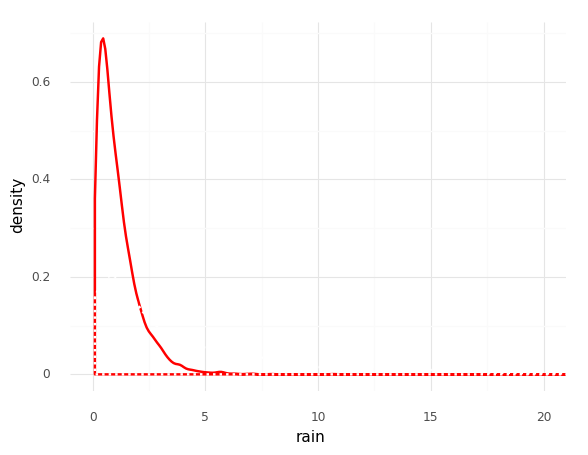

<ggplot: (-9223371900113943790)>

In [13]:
# ANALYSIS 

# Plot using ggplot2 for python (plotnine). Currently not too pretty, need to find how to mend the looks
(ggplot(ensemble_df_mean.where(ensemble_df_mean["rain"]>0.1))+
  geom_density(mapping= aes(x = "rain"), color="red", size=1) +
  geom_density(data=silo_df.where(silo_df["rain"]>0.1), mapping= aes(x = "rain"), color="white", size=1, linetype='dotted') +
  theme_minimal()+
  coord_cartesian(xlim =(0, 20))
  )

In [14]:
# Calculate ensemble performance metrics (based on http://www.cawcr.gov.au/projects/verification/)
# We won't use correlation as we're not interested in predicting daily weather but the actual pattern of climate
fcast_vs_obs = ensemble_df_mean.merge(silo_df, on= 'date')

fcast_vs_obs.rename(columns = {"date":"date", "ens":"ens", "rad_x":"rad.fcast","tmax_x":"tmax.fcast","rain_x":"rain.fcast","tmin_x":"tmin.fcast","rad_y":"rad.obs","tmax_y":"tmax.obs","tmin_y":"tmin.obs","rain_y":"rain.obs","vp":"vp.obs","evap":"evap.obs"}, inplace=True)

In [15]:
# Mean error - Answers the question: What is the average forecast error?
# We don't really want this for AgScore but it's informative
fcast_vs_obs["error"] = fcast_vs_obs["rain.fcast"] - fcast_vs_obs["rain.obs"]
mean_error = fcast_vs_obs["error"].mean()
print (mean_error)

-0.008851560323785666


In [16]:
# Multiplicative bias - Answers the question: How does the average forecast magnitude compare to the average observed magnitude?
# Bias = mean of forecast divided by mean of observations
bias = fcast_vs_obs["rain.fcast"].mean() / fcast_vs_obs["rain.obs"].mean()
print (bias)

# Next, we need more metrics...

0.9909463448076238


In [1]:
ncdump nc

SyntaxError: invalid syntax (<ipython-input-1-c20b9ef9cc39>, line 1)